<a href="https://colab.research.google.com/github/emiliocicese/CDSI_2023/blob/main/Procesamiento_de_Adio/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Emilio Hernández Arellano

Ciencia de Datos para Sensores Inteligentes

La carpeta en Drive: https://drive.google.com/drive/folders/15WWp_g-Rm-xTF27K5YHSF9OEx1pqakQw?usp=share_link


Esta carpeta contiene:

* El notebook original.
* La carpeta My_records, la cual pertenece a los audios de las personas externas que me enviaron sus audios.
* La capeta Eva, la cual pertenece al audio registrado por el robot. 

Cabe mencionar que si bien es cierto se tenía el registro de 20 personas, en mi caso, si quería extraer las características de 13 o más personas, Python me entregaría una variable de None Type Object, al momento de extraer las características, por lo que se optó unicamente a 180 registros.

# Preparano el entorno

## Importando librerías y conectando a Drive

In [2]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa 
import librosa.display
from sklearn.preprocessing import StandardScaler #Util para el escalamiento durante el PCA
from sklearn.decomposition import PCA #Modulo para el PCA
from sklearn.model_selection import train_test_split #Separación de datos
from sklearn.metrics import plot_confusion_matrix #Matriz de Confusión
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import soundfile 
import glob
import os
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creando las funciones necesarias

Tales como:

* Importación de los datos
* Extracción de características

In [4]:
def feature_extraction (file, **kwargs):
    result = np.array([])
    sign_det = kwargs.get("sign_det")
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    tonnetz = kwargs.get("tonnetz")
    x, sample_rate = soundfile.read(file,dtype="float32")
    #Devolviendo la entrada de audio como arreglo numpy y la frecuencia de muestreo
    if sign_det:
        return x, sample_rate
    else:
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=x,sr=s,n_mfcc=40).T, axis=0)
            result = np.hstack((result,mfccs))
        if mel:
            mels = np.mean(librosa.feature.melspectrogram(y=x,sr=s).T, axis = 0)
            result = np.hstack((result,mels))
        if chroma:
            stft = np.abs(librosa.stft(x))
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(x), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
        return result

In [5]:
def import_data(ospath):
  features = []
  label = []
  try:
    for file in glob.glob(ospath):
      basename = basename = os.path.basename(file)
      emotion = basename.split("_")[0]
      feature = feature_extraction(file,mfcc=True, chroma=True, mel=True)
      features.append(feature)
      label.append(emotion)
    features_array = np.array(features)
    return features_array, label
  except:
    pass

# Visualizando en un solo archivo

In [7]:

file_test = "/content/drive/MyDrive/CDSI/Practica_1/Eva/Martha/Enojo_01.wav"

In [8]:
x,s = feature_extraction(file_test, sign_det = True)
IPython.display.Audio(x, rate=s)

In [9]:
#Displaying details:

print("\n Shape of signal: ", x.shape)
print("\n Signal type: ", x.dtype)
print("\n Sample Frecuency: ", s)
print("\n Singal Duration: ", round ( x.shape[0] / float(s), 1 ), " seconds")


 Shape of signal:  (95232,)

 Signal type:  float32

 Sample Frecuency:  44100

 Singal Duration:  2.2  seconds


(40, 187)

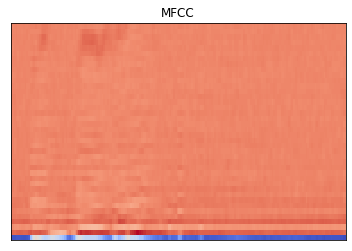

In [10]:
plt.figure()
mfcc_individual = librosa.feature.mfcc(y=x,sr=s,n_mfcc=40)
librosa.display.specshow(mfcc_individual)
plt.title("MFCC")
mfcc_individual.shape

(128, 187)

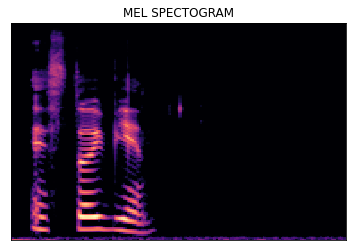

In [11]:
mel_individual = librosa.feature.melspectrogram(y=x,sr=s)
log_mel_individual = librosa.amplitude_to_db(mel_individual, ref=np.max)
plt.figure()
librosa.display.specshow(log_mel_individual, sr = s)
plt.title("MEL SPECTOGRAM")
mel_individual.shape

# Evaluando para todos los archivos

Para la extracción de características, se eligieron el Chroma, Espectograma de Mel y MFCC. Dado que estos componentes son arreglos bidimensionales, se promediaron todas las filas, para obtener un arreglo de 1d por cada característica.

In [12]:
path = "/content/drive/MyDrive/CDSI/Practica_1/Eva/*/*.wav"
data_feature, label = import_data(path)

In [13]:
data_feature.shape

(180, 180)

In [ ]:
len(label)

180

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
#model = DecisionTreeClassifier(max_depth=10)
model = RandomForestClassifier(n_estimators=100, random_state=42)
x_train,x_test,y_train,y_test = train_test_split(data_feature,
                                                 label,test_size = 0.2,
                                                 random_state=15)
model.fit(x_train, y_train)
y_pred= model.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.75
              precision    recall  f1-score   support

     Enojado       1.00      1.00      1.00         2
       Enojo       0.67      0.60      0.63        10
       Feliz       0.69      0.82      0.75        11
      Triste       0.83      0.77      0.80        13

    accuracy                           0.75        36
   macro avg       0.80      0.80      0.80        36
weighted avg       0.75      0.75      0.75        36



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


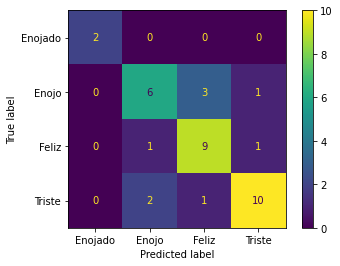

In [15]:
plot_confusion_matrix(model,x_test,y_test)

Como se muestra para el caso de 180 muestras se y con un conjunto de prueba del 20%, el clasificador obtuvo 75% de accuracy. Si bien es cierto el número de datos supera con creces a 180 (lo que equivale a 12 carpetas o 12 personas), Python empieza a arrojar un error puesto que devuelve un NON TYPE OBJECT en la variable feature de la función **Feature Extraction**

Se observa que la emoción la cual tuvo una mayor presición, fue la de tristeza, tras realizar el entrenamiento

# Evaluando Algoritmo con un audio externo

Como se muestra para el caso de 180 muestras y con un


Dado que mis participantes se encuentran en el estado de Puebla, se les solicitó que grabaran un audio de Whatsapp en el cual dijeran la palabra: 
"Estoy bien", ya sea tristes, enojados y felices. A continuación se utilizó un audio de muestra para este experimento. Dado lo tengo en carpetas
distintas, se indicó la ruta junto con el nombre en la variable Voice_Record del audio que me adjuntaron

In [ ]:
#Importando librerías

from gtts import gTTS
from IPython.display import Audio
from IPython.display import display

In [ ]:
text = "Hola. ¿Cómo estás?."
language = "es-us" #Español mexicano

In [ ]:
robot_voice = gTTS(text = text, lang=language)
robot_voice.save("Ask.mp3")
robot_voice_file = "Ask.mp3"

In [ ]:
Audio(robot_voice_file,autoplay= False)

In [ ]:
text_indications = "Por favor introduce el nombre de tu archivo de texto en la variable Voice_Record. En caso de que la ruta sea distinta, indicar el PATH"
robot_voice_indications = gTTS(text = text_indications, lang = language, slow = True)
robot_voice_indications.save("Ask1.mp3")
robot_voice_indications_file = "Ask1.mp3"
Audio(robot_voice_indications_file, autoplay=False)

In [ ]:
voice_record = "/content/drive/MyDrive/CDSI/Practica_1/My_records/Feliz_s1.wav"
x,fs = librosa.load(voice_record)
IPython.display.Audio(voice_record)

In [ ]:
feature_voice_record = feature_extraction(voice_record,mfcc=True, chroma=True, mel=True)
feature_voice_record = np.expand_dims(feature_voice_record, axis=0)
emotion_predicted = model.predict(feature_voice_record)

In [ ]:

result = "Te siento %s" % emotion_predicted 
robot_voice_result = gTTS(text = result, lang = language, slow = True)
robot_voice_result.save("Final.mp3")
robot_voice_result_file = "Final.mp3"
IPython.display.Audio(robot_voice_result_file)

## Evaluando la matriz de Confusión con los datos que me dieron

Para esta parte se les solicitó a mis concactos, que realizaran una grabación de audio diciendo: **Estoy bien** de manera feliz, triste y enojada. Así mismo que me enviaran a modo de comentario, la forma en la cual lo hicieron. De modo que se realizó un etiquetado manual. 

Los archivos tienen la siguiente estructura:
emoción_si.wav

Donde:
* Emoción: Corresponde a la etiqueta de la clase

* Si: Al número de sujeto

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


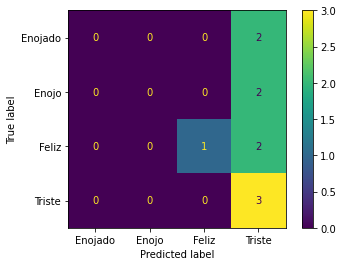

In [17]:
my_path = "/content/drive/MyDrive/CDSI/Practica_1/My_records/*.wav"
X, Y = import_data(my_path)
plot_confusion_matrix(model,X,Y)

Como se mencionó con anterioridad se hizo un etiquetado manual de los audios compartidos por mis conocidos, por lo que a continuación se presenta la matriz de confusión sobre el desempeño del algoritmo con mis registros propios.